In [ ]:
# load base package for the tasks from pytorch
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

Load data

In [ ]:
# install transformers
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.8 MB 14.1 MB/s 
     |████████████████████████████████| 182 kB 56.5 MB/s 
     |████████████████████████████████| 7.6 MB 56.4 MB/s 


In [ ]:
# install sentencepiece
!pip install "sentencepiece==0.1.96"

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.2 MB 24.1 MB/s 


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
torch.cuda.get_device_name(0)

'Tesla T4'

In [ ]:
import pickle
import pandas as pd
from google.colab import drive
# Connect to google drive
drive.mount('/content/gdrive')

# Load data and set labels
#data = pickle.load(open('gdrive/My Drive/Dissertation/formspring_data.pkl', 'rb'))
df = pd.read_csv('gdrive/My Drive/Dissertation/enriched_processed_form+tweet.csv', index_col=0)

Mounted at /content/gdrive


In [ ]:
df.label.value_counts()

1    19553
0    19526
Name: label, dtype: int64

In [ ]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
No_of_Characters,39079.0,122.354948,76.555517,7.0,64.0,107.0,144.0,910.0
No_of_Words,39079.0,26.075718,16.100767,3.0,14.0,23.0,33.0,99.0
No_of_sentence,39079.0,2.058190,1.268395,1.0,1.0,2.0,3.0,30.0
label,39079.0,0.500345,0.500006,0.0,0.0,1.0,1.0,1.0
sent_length,39079.0,20.579237,13.958837,1.0,10.0,17.0,26.0,93.0


In [ ]:
df = df.dropna(axis=0)

In [ ]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
No_of_Characters,39079.0,122.354948,76.555517,7.0,64.0,107.0,144.0,910.0
No_of_Words,39079.0,26.075718,16.100767,3.0,14.0,23.0,33.0,99.0
No_of_sentence,39079.0,2.058190,1.268395,1.0,1.0,2.0,3.0,30.0
label,39079.0,0.500345,0.500006,0.0,0.0,1.0,1.0,1.0
sent_length,39079.0,20.579237,13.958837,1.0,10.0,17.0,26.0,93.0


In [ ]:
X = df['clean_text']
y = df['label']

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=40, stratify=y)

In [ ]:
y_train.value_counts()

1    17598
0    17573
Name: label, dtype: int64

In [ ]:
X_train.values

array(['hey you know that smurfet is the only female smurf do you think shes hoe nah',
       'did even watch the full video the indian man steped right into the crowd the boys didnt do anything except claims harasment after black kid said jesus was black dont say white bois white and friends with tons of colored whatchu got up rn is racism',
       'am down facebok friends since yesterday i have not checked the twitter count that is fine in high schol ached to be the popular girl was very much not was bullied every single day for being unapologeticaly myself just for being me',
       ...,
       'swear some people who support trump are legit brainwashed on the other side no wonder they can convince christian conservatives to kill christians in the middle east fund radical islam they sneak you you eat it up some of you are really that easy to manipulate',
       'honestly think the roles of high school are going to completely change in the future kids will be bullied for being homopho

In [ ]:
sentences = X_train.values
labels = y_train.values

## XLM-ROBERTA tokenizer

In [ ]:
# load tokenizer
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained('xlm-roberta-base')

Downloading:   0%|          | 0.00/615 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

In [ ]:
# Print the original sentence.
print(' Original: ', sentences[0])

# Print the sentence split into tokens.
print('Tokenized: ', tokenizer.tokenize(sentences[0]))

# Print the sentence mapped to token ids.
print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(sentences[0])))

 Original:  hey you know that smurfet is the only female smurf do you think shes hoe nah
Tokenized:  ['▁hey', '▁you', '▁know', '▁that', '▁s', 'mur', 'fet', '▁is', '▁the', '▁only', '▁female', '▁s', 'mur', 'f', '▁do', '▁you', '▁think', '▁she', 's', '▁hoe', '▁nah']
Token IDs:  [28192, 398, 3714, 450, 91, 5130, 29362, 83, 70, 4734, 117776, 91, 5130, 420, 54, 398, 5351, 2412, 7, 4621, 74890]


## Tokenize dataset

In [ ]:
# Find maximum length based on our dataset
max_len = 0

# For every sentence...
for sent in sentences:

    # Tokenize the text and add `[CLS]` and `[SEP]` tokens.
    input_ids = tokenizer.encode(sent, add_special_tokens=True)

    # Update the maximum sentence length.
    max_len = max(max_len, len(input_ids))

print('Max sentence length: ', max_len)

Max sentence length:  138


In [ ]:
# Create empty lists to store outputs
input_ids = []
attention_masks = []

# For every sentence...
for sent in sentences:
    # `encode_plus` will:
    #    (1) Tokenize the sentence
    #    (2) Add the `[CLS]` and `[SEP]` token to the start and end
    #    (3) Truncate/Pad sentence to max length
    #    (4) Map tokens to their IDs
    #    (5) Create attention mask
    #    (6) Return a dictionary of outputs
    encoded_sent = tokenizer.encode_plus(
        text=sent,  # Preprocess sentence
        add_special_tokens=True,        # Add `[CLS]` and `[SEP]`
        max_length=150,             # Max length to truncate/pad
        pad_to_max_length=True,         # Pad sentence to max length
        return_attention_mask=True,      # Return attention mask
        truncation = True
        )
    # Add the outputs to the lists
    input_ids.append(encoded_sent.get('input_ids'))
    attention_masks.append(encoded_sent.get('attention_mask'))
# Convert lists to tensors
input_ids = torch.tensor(input_ids)
attention_masks = torch.tensor(attention_masks)
labels = torch.tensor(labels)

/usr/local/lib/python3.8/dist-packages/transformers/tokenization_utils_base.py:2336: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [ ]:
# Print sentence 0, now as a list of IDs.
print('Original: ', sentences[0])
print('Token IDs:', input_ids[0])

Original:  hey you know that smurfet is the only female smurf do you think shes hoe nah
Token IDs: tensor([     0,  28192,    398,   3714,    450,     91,   5130,  29362,     83,
            70,   4734, 117776,     91,   5130,    420,     54,    398,   5351,
          2412,      7,   4621,  74890,      2,      1,      1,      1,      1,
             1,      1,      1,      1,      1,      1,      1,      1,      1,
             1,      1,      1,      1,      1,      1,      1,      1,      1,
             1,      1,      1,      1,      1,      1,      1,      1,      1,
             1,      1,      1,      1,      1,      1,      1,      1,      1,
             1,      1,      1,      1,      1,      1,      1,      1,      1,
             1,      1,      1,      1,      1,      1,      1,      1,      1,
             1,      1,      1,      1,      1,      1,      1,      1,      1,
             1,      1,      1,      1,      1,      1,      1,      1,      1,
             1,      

## Train - Validation split

In [ ]:
# # Use 90% for training and 10% for validation
# from sklearn.model_selection import train_test_split
# train_inputs, validation_inputs, train_labels, validation_labels, train_masks, validation_masks = train_test_split(input_ids, labels, attention_masks, random_state=2018, test_size=0.1, stratify=labels)

In [ ]:
from torch.utils.data import TensorDataset

# Combine the training inputs into a TensorDataset.
train_dataset = TensorDataset(input_ids, attention_masks, labels)
#validation_dataset = TensorDataset(validation_inputs, validation_masks, validation_labels)

In [ ]:
import numpy as np
class_sample_count = np.unique(labels, return_counts=True)[1]

In [ ]:
class_sample_count

array([17573, 17598])

In [ ]:
from torch.utils.data import WeightedRandomSampler

weight = 1. / class_sample_count
samples_weight = weight[labels]
samples_weight = torch.from_numpy(samples_weight)
sampler = WeightedRandomSampler(samples_weight, len(samples_weight))

In [ ]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
batch_size = 32

# Create the DataLoaders for our training and validation sets.
# We'll take training samples in random order. 
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = sampler, # Select batches based on weights
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
# validation_dataloader = DataLoader(
#             validation_dataset, # The validation samples.
#             sampler = SequentialSampler(validation_dataset), # Pull out batches sequentially.
#             batch_size = batch_size # Evaluate with this batch size.
#         )

##Training the classification model

In [ ]:
from transformers import XLMRobertaForSequenceClassification, AdamW, get_linear_schedule_with_warmup
model = XLMRobertaForSequenceClassification.from_pretrained(
    "xlm-roberta-base", 
    # Specify number of classes
    num_labels = 2, 
    # Whether the model returns attentions weights
    output_attentions = False,
    # Whether the model returns all hidden-states 
    output_hidden_states = False
)

Downloading:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

Some weights of the model checkpoint at xlm-roberta-base were not used when initializing XLMRobertaForSequenceClassification: ['lm_head.layer_norm.bias', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense

In [ ]:
model.cuda()

## Optimizer and Learning rate scheduler

In [ ]:
# Optimizer & Learning Rate Scheduler
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, 
                  eps = 1e-8 
                )

/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
# Number of training epochs
epochs = 4
# Total number of training steps is number of batches * number of epochs.
total_steps = len(train_dataloader) * epochs
# Create the learning rate scheduler
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps = 0,
                                            num_training_steps = total_steps)

### Training Loop

In [ ]:
# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [ ]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [ ]:
import gc
gc.collect()

25

In [ ]:
if torch.cuda.is_available():
  device = torch.device("cuda")
else:
  device = torch.device("cpu")

type(device)

torch.device

In [ ]:
import random
import numpy as np

# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128

# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# We'll store a number of quantities such as training and validation loss, 
# validation accuracy, and timings.
training_stats = []

# Measure the total training time for the whole run.
total_t0 = time.time()

# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0

    # Put the model into training mode. Don't be mislead--the call to 
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the 
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because 
        # accumulating the gradients is "convenient while training RNNs". 
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        model.zero_grad()        

        # Perform a forward pass (evaluate the model on this training batch).
        # The documentation for this `model` function is here: 
        # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
        # It returns different numbers of parameters depending on what arguments
        # arge given and what flags are set. For our useage here, it returns
        # the loss (because we provided labels) and the "logits"--the model
        # outputs prior to activation.
        tmp = model(b_input_ids, 
                             token_type_ids=None, 
                             attention_mask=b_input_mask, 
                             labels=b_labels)
        loss, logits = tmp[0], tmp[1]
        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor.
        total_train_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)            
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))
        
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    # print("")
    # print("Running Validation...")

    # t0 = time.time()

    # # Put the model in evaluation mode--the dropout layers behave differently
    # # during evaluation.
    # model.eval()

    # # Tracking variables 
    # total_eval_accuracy = 0
    # total_eval_loss = 0
    # nb_eval_steps = 0

    # # Evaluate data for one epoch
    # for batch in validation_dataloader:
        
    #     # Unpack this training batch from our dataloader. 
    #     #
    #     # As we unpack the batch, we'll also copy each tensor to the GPU using 
    #     # the `to` method.
    #     #
    #     # `batch` contains three pytorch tensors:
    #     #   [0]: input ids 
    #     #   [1]: attention masks
    #     #   [2]: labels 
    #     b_input_ids = batch[0].to(device)
    #     b_input_mask = batch[1].to(device)
    #     b_labels = batch[2].to(device)
        
    #     # Tell pytorch not to bother with constructing the compute graph during
    #     # the forward pass, since this is only needed for backprop (training).
    #     with torch.no_grad():        

    #         # Forward pass, calculate logit predictions.
    #         # token_type_ids is the same as the "segment ids", which 
    #         # differentiates sentence 1 and 2 in 2-sentence tasks.
    #         # The documentation for this `model` function is here: 
    #         # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
    #         # Get the "logits" output by the model. The "logits" are the output
    #         # values prior to applying an activation function like the softmax.
    #         temp = model(b_input_ids, 
    #                                token_type_ids=None, 
    #                                attention_mask=b_input_mask,
    #                                labels=b_labels)
    #         (loss, logits) = temp[0], temp[1]
            
    #     # Accumulate the validation loss.
    #     total_eval_loss += loss.item()

    #     # Move logits and labels to CPU
    #     logits = logits.detach().cpu().numpy()
    #     label_ids = b_labels.to('cpu').numpy()

    #     # Calculate the accuracy for this batch of test sentences, and
    #     # accumulate it over all batches.
    #     total_eval_accuracy += flat_accuracy(logits, label_ids)
        

    # # Report the final accuracy for this validation run.
    # avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    # print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    # # Calculate the average loss over all of the batches.
    # avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    # # Measure how long the validation run took.
    # validation_time = format_time(time.time() - t0)
    
    # print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    # print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Training Time': training_time
        }
    )

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 4 ========
Training...
  Batch    40  of  1,100.    Elapsed: 0:00:36.
  Batch    80  of  1,100.    Elapsed: 0:01:11.
  Batch   120  of  1,100.    Elapsed: 0:01:45.
  Batch   160  of  1,100.    Elapsed: 0:02:19.
  Batch   200  of  1,100.    Elapsed: 0:02:54.
  Batch   240  of  1,100.    Elapsed: 0:03:28.
  Batch   280  of  1,100.    Elapsed: 0:04:03.
  Batch   320  of  1,100.    Elapsed: 0:04:37.
  Batch   360  of  1,100.    Elapsed: 0:05:11.
  Batch   400  of  1,100.    Elapsed: 0:05:46.
  Batch   440  of  1,100.    Elapsed: 0:06:20.
  Batch   480  of  1,100.    Elapsed: 0:06:54.
  Batch   520  of  1,100.    Elapsed: 0:07:29.
  Batch   560  of  1,100.    Elapsed: 0:08:03.
  Batch   600  of  1,100.    Elapsed: 0:08:37.
  Batch   640  of  1,100.    Elapsed: 0:09:12.
  Batch   680  of  1,100.    Elapsed: 0:09:46.
  Batch   720  of  1,100.    Elapsed: 0:10:20.
  Batch   760  of  1,100.    Elapsed: 0:10:55.
  Batch   800  of  1,100.    Elapsed: 0:11:29.
  Batch   840  of

In [ ]:
torch.save(model, 'gdrive/My Drive/Dissertation/enriched_form+tweet_xlmrobertamodel')
saved_model = torch.load('gdrive/My Drive/Dissertation/enriched_form+tweet_xlmrobertamodel')

In [ ]:
type(saved_model)

transformers.models.xlm_roberta.modeling_xlm_roberta.XLMRobertaForSequenceClassification

###Summary of training process

In [ ]:
import pandas as pd

# Display floats with two decimal places.
pd.set_option('precision', 2)

# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# A hack to force the column headers to wrap.
#df = df.style.set_table_styles([dict(selector="th",props=[('max-width', '70px')])])

# Display the table.
df_stats

,Training Loss,Training Time
epoch,,
1,0.34,0:15:46
2,0.26,0:15:43
3,0.22,0:15:43
4,0.20,0:15:43


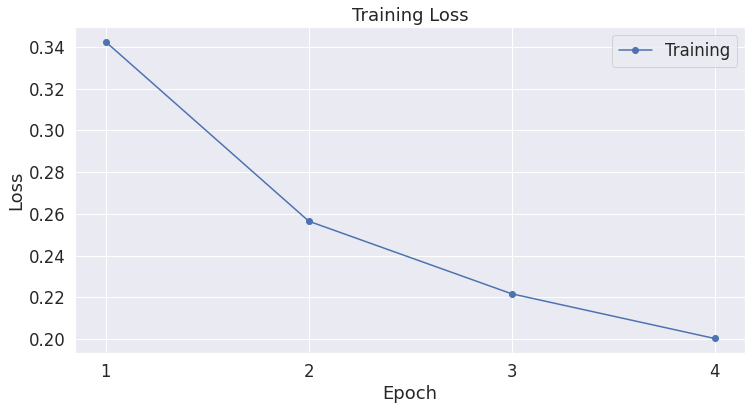

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
#plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

##Performance On Test Set

In [ ]:
pred_sentences = X_test
y_true = y_test.values

In [ ]:
"""Perform required preprocessing steps for pretrained BERT.
@param    data (np.array): Array of texts to be processed.
@return   input_ids (torch.Tensor): Tensor of token ids to be fed to a model.
@return   attention_masks (torch.Tensor): Tensor of indices specifying which
              tokens should be attended to by the model.
"""
# Create empty lists to store outputs
t_input_ids = []
t_attention_masks = []

# For every sentence...
for s in pred_sentences:
    # `encode_plus` will:
    #    (1) Tokenize the sentence
    #    (2) Add the `[CLS]` and `[SEP]` token to the start and end
    #    (3) Truncate/Pad sentence to max length
    #    (4) Map tokens to their IDs
    #    (5) Create attention mask
    #    (6) Return a dictionary of outputs
    p_encoded_sent = tokenizer.encode_plus(
        text=s,  # Preprocess sentence
        add_special_tokens=True,        # Add `[CLS]` and `[SEP]`
        max_length=512,             # Max length to truncate/pad
        pad_to_max_length=True,         # Pad sentence to max length
        return_attention_mask=True,      # Return attention mask
        truncation = True
        )
    # Add the outputs to the lists
    t_input_ids.append(p_encoded_sent.get('input_ids'))
    t_attention_masks.append(p_encoded_sent.get('attention_mask'))
# Convert lists to tensors
t_input_ids = torch.tensor(t_input_ids)
t_attention_masks = torch.tensor(t_attention_masks)
t_labels = torch.tensor(y_true)

/usr/local/lib/python3.8/dist-packages/transformers/tokenization_utils_base.py:2336: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [ ]:
t_input_ids.size()

torch.Size([3908, 512])

In [ ]:
from torch.utils.data import TensorDataset

# Combine the training inputs into a TensorDataset.
prediction_data = TensorDataset(t_input_ids, t_attention_masks, t_labels)

In [ ]:
from torch.utils.data import DataLoader, SequentialSampler

# The DataLoader needs to know our batch size for training, so we specify it 
# here. For fine-tuning BERT on a specific task, the authors recommend a batch 
# size of 16 or 32.
batch_size = 16
# For Prediction the order doesn't matter, so we'll just read them sequentially.
prediction_dataloader = DataLoader(
            prediction_data, # The test samples.
            sampler = SequentialSampler(prediction_data), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

### Evaluate on Test set

In [ ]:
import torch
from google.colab import drive
# Connect to google drive
drive.mount('/content/gdrive')
model = torch.load('gdrive/My Drive/Dissertation/enriched_form+tweet_xlmrobertamodel')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
# Prediction on test set

print('Predicting labels for {:,} test sentences...'.format(len(prediction_data)))

# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions , true_labels = [], []

# Predict 
for batch in prediction_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch
  
  # Telling the model not to compute or store gradients, saving memory and 
  # speeding up prediction
  with torch.no_grad():
      # Forward pass, calculate logit predictions
      outputs = model(b_input_ids, token_type_ids=None, 
                      attention_mask=b_input_mask)

  logits = outputs[0]

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  
  # Store predictions and true labels
  predictions.append(logits)
  true_labels.append(label_ids)

print('    DONE.')

Predicting labels for 3,908 test sentences...
    DONE.


In [ ]:
import numpy as np

# Combine the results across all batches. 
flat_predictions = np.concatenate(predictions, axis=0)

# For each sample, pick the label (0 or 1) with the higher score.
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()

# Combine the correct labels for each batch into a single list.
flat_true_labels = np.concatenate(true_labels, axis=0)

Accuracy: 86.34%
F1 score: 86.35%
Precision: 86.31%
Recall: 86.39%
Accuracy 0.86


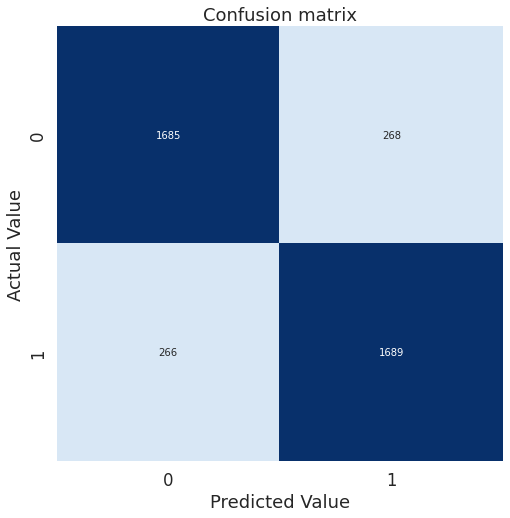

              precision    recall  f1-score   support

           0       0.86      0.86      0.86      1953
           1       0.86      0.86      0.86      1955

    accuracy                           0.86      3908
   macro avg       0.86      0.86      0.86      3908
weighted avg       0.86      0.86      0.86      3908



In [ ]:
from sklearn.metrics import accuracy_score, roc_curve, auc, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

accuracy = accuracy_score(flat_true_labels, flat_predictions)
print(f'Accuracy: {accuracy*100:.2f}%')
f1 = f1_score(flat_true_labels, flat_predictions)
print(f'F1 score: {f1*100:.2f}%')
precision = precision_score(flat_true_labels, flat_predictions)
print(f'Precision: {precision*100:.2f}%')
recall = recall_score(flat_true_labels, flat_predictions)
print(f'Recall: {recall*100:.2f}%')

c_matrix =confusion_matrix(flat_true_labels,flat_predictions)
clr = classification_report(flat_true_labels,flat_predictions)
accuracy = accuracy_score(flat_true_labels, flat_predictions)
print("Accuracy", round(accuracy,2) )
plt.figure(figsize=(8,8))
sns.heatmap(c_matrix,annot=True, fmt='g', vmin=0, cbar=False, cmap='Blues')
plt.xlabel("Predicted Value")
plt.ylabel("Actual Value")
plt.title("Confusion matrix")
plt.show()
print(clr)

AUC: 0.8634


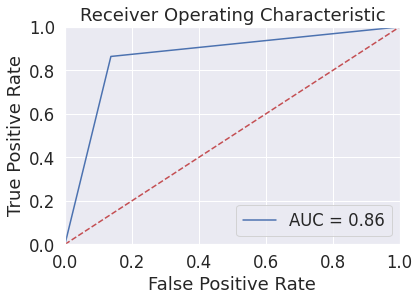

In [ ]:
fpr, tpr, threshold = roc_curve(flat_true_labels,flat_predictions)
roc_auc = auc(fpr, tpr)
print(f'AUC: {roc_auc:.4f}')

# Plot ROC AUC
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()